In [1]:
import os
import torchaudio
import torch
import matplotlib.pyplot as plt
from torch.nn import Module, Linear, Sigmoid, LSTM, BCELoss, Conv2d, MaxPool2d, LayerNorm, MultiheadAttention, Dropout
from torch.optim import Adam
import torch.nn.functional as F
from pytorch_model_summary import summary
from tqdm import tqdm
import numpy as np
import math
import pickle

In [2]:
from DataLoader import DataLoaderAll

X,Y,speech,mix1,X_complex = DataLoaderAll.data_loader(n_noise=100)

# MaskNet + Training

In [3]:
class PositionalEncoding(Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [8]:
# MASK NET
SAMPLE_RATE = 16000
INPUT_CHANNEL = 4 # Always two -> Real and Imaginary part 
D_TF = 1024#1024

class MaskNet(Module):
    def __init__(self,noise=False):
        super(MaskNet, self).__init__()

        self.pe = PositionalEncoding(d_model=196)
        self.ln11 = LayerNorm(normalized_shape=(196))
        self.ln12 = LayerNorm(normalized_shape=(196))
        self.mha1 = MultiheadAttention(embed_dim=196,num_heads=14,dropout=0.1)
        self.lintf1 = Linear(in_features=196,out_features=D_TF)#1024 instead of 256!
        self.lintf12 = Linear(in_features=D_TF,out_features=196)

        self.pe2 = PositionalEncoding(d_model=196)
        self.ln21 = LayerNorm(normalized_shape=(196))
        self.ln22 = LayerNorm(normalized_shape=(196))
        self.mha2 = MultiheadAttention(embed_dim=196,num_heads=14,dropout=0.1)
        self.lintf2 = Linear(in_features=196,out_features=D_TF)#1024 instead of 256!
        self.lintf22 = Linear(in_features=D_TF,out_features=196)

        self.fc = Linear(in_features=4,out_features=1)
        self.sigmoid = Sigmoid()

    def forward(self,x):
        
        x = x.reshape(INPUT_CHANNEL,513,196)

        # Transformer 1
        y = self.pe(x)
        z = self.ln11(y)
        z, _ = self.mha1(z,z,z)
        z_2 = z+y
        z = self.ln12(z_2)
        z = self.lintf1(z)
        z = F.relu(z)
        z = self.lintf12(z)
        x = z+z_2+x

        # Transformer 2
        y = self.pe(x)
        z = self.ln21(y)
        z, _ = self.mha2(z,z,z)
        z_2 = z+y
        z = self.ln22(z_2)
        z = self.lintf2(z)
        z = F.relu(z)
        z = self.lintf22(z)
        x = z+z_2+x
        
        x = x.view(513,196,4)

        x = self.fc(x)
        speech_pred = self.sigmoid(x)
        return speech_pred.reshape(513,-1)#, noise_pred

print(summary(MaskNet(),torch.zeros((513, 196, 4))))

---------------------------------------------------------------------------------------
           Layer (type)                   Output Shape         Param #     Tr. Param #
   PositionalEncoding-1                  [4, 513, 196]               0               0
            LayerNorm-2                  [4, 513, 196]             392             392
   MultiheadAttention-3     [4, 513, 196], [513, 4, 4]         154,448         154,448
            LayerNorm-4                  [4, 513, 196]             392             392
               Linear-5                 [4, 513, 1024]         201,728         201,728
               Linear-6                  [4, 513, 196]         200,900         200,900
            LayerNorm-7                  [4, 513, 196]             392             392
   MultiheadAttention-8     [4, 513, 196], [513, 4, 4]         154,448         154,448
            LayerNorm-9                  [4, 513, 196]             392             392
              Linear-10                 [4

In [13]:
EPOCHS = 100#30#500
LEN_TRAIN = 2000
NUM_CHANNEL = 2 # Number of Mic Inputs (>=2 for BF)
REFERENCE_CHANNEL = 0
INIT_LR = 0.001#0.0001
BATCH_SIZE = 1#64
LEARN_LOSS_PARAMS = False
device =  torch.device('cuda:3') if torch.cuda.is_available() else torch.device('cpu')

model = MaskNet().to(device)
model= torch.nn.DataParallel(model,device_ids=[3])

lossBCE = BCELoss()

opt = Adam(model.parameters(), lr=INIT_LR)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=opt, gamma=0.96,last_epoch=-1)

H = {
    "train_loss":[],
    "train_acc":[],
    "val_loss":[],
    "val_acc":[]
}

def check_accuracy_training(speech_pred, y_s):
    speech_pred = (speech_pred>0.15).float()
    return float(torch.sum((speech_pred == y_s).float())/torch.sum(torch.ones(513,speech_pred.shape[1])))

def check_accuracy_validation(model):
    example_nr = int(np.random.random()*(len(X)-LEN_TRAIN)+LEN_TRAIN)
    model.eval()
    pred = model(X[example_nr])
    val_loss = lossBCE(pred,Y[example_nr][0])
    pred = (pred>0.15).float()
    model.train()
    return float(torch.sum((pred == Y[example_nr][0]).float())/torch.sum(torch.ones(513,X[example_nr].shape[1]))),val_loss

print("[INFO] training the network...")
#X = stft_mix[:50].to(device)
#Y = Y.to(device)
X = X.to(device)
Y = Y.to(device)
trainX = X[:LEN_TRAIN]
trainY = Y

for epoch in range(0, EPOCHS):
    print("Epoch:",str(epoch+1)+"/"+str(EPOCHS))
    # Train Mode
    model.train()
    
    # Initialize
    totalTrainLoss = 0
    totalValLoss = 0
    trainCorrect = 0
    valCorrect = 0

    for i in tqdm(range(0,len(trainX))): # Iterate over Training Examples
        y_s = trainY[i][0] # 0 speech only
        x = trainX[i]
        speech_pred=model(x)#, noise_pred = model(x)
        loss = lossBCE(speech_pred,y_s) #+ lossMSE(noise_pred,y_n)
        # zero out the gradients, perform the backpropagation step, and update the weights
        opt.zero_grad()
        loss.backward()
        opt.step()
        H["train_acc"].append(check_accuracy_training(speech_pred,y_s))
        H["train_loss"].append(float(loss))
        if i % 10 == 0:
            #lr_scheduler.step()
            val_acc, val_loss = check_accuracy_validation(model)
            H["val_acc"].append(val_acc)
            H["val_loss"].append(float(val_loss))
    # Print results of Epoch        
    print("Average Training Accuracy in Epoch",str(epoch+1),":",np.mean(np.array(H["train_acc"])))
    print("Total Training Loss in Epoch",str(epoch+1),":",np.sum(np.array(H["train_loss"])))
    print("Average Validation Accuracy in Epoch",str(epoch+1),":",np.mean(np.array(H["val_acc"])))
    print("Total Validation Loss in Epoch",str(epoch+1),":",np.sum(np.array(H["val_loss"])))
    # Save Model after Epoch       
    MODEL_SAVE_PATH = '/project/data_asr/CHiME5/data/librenoise/models/TFall'
    if (epoch+1)%10 == 0:
        torch.save(model.state_dict(), MODEL_SAVE_PATH + "epoch" + str(epoch+1) + ".pt")
    print(totalTrainLoss)
PICKLE_SAVE_PATH = '/project/data_asr/CHiME5/data/librenoise/models/params.pkl'
torch.save(model.state_dict(), MODEL_SAVE_PATH + "final" + ".pt")
with open(PICKLE_SAVE_PATH, 'wb') as f:
    pickle.dump(H, f)

[INFO] training the network...
Epoch: 1/100


100%|██████████| 2000/2000 [00:23<00:00, 83.57it/s]


Average Training Accuracy in Epoch 1 : 0.6396199718862772
Total Training Loss in Epoch 1 : 934.4407936483622
Average Validation Accuracy in Epoch 1 : 0.674679527580738
Total Validation Loss in Epoch 1 : 94.6800587438047
0
Epoch: 2/100


100%|██████████| 2000/2000 [00:23<00:00, 85.52it/s] 


Average Training Accuracy in Epoch 2 : 0.6397005877867341
Total Training Loss in Epoch 2 : 1868.5441866070032
Average Validation Accuracy in Epoch 2 : 0.6685296309739351
Total Validation Loss in Epoch 2 : 188.23556907474995
0
Epoch: 3/100


100%|██████████| 2000/2000 [00:22<00:00, 87.53it/s] 


Average Training Accuracy in Epoch 3 : 0.6397910181408127
Total Training Loss in Epoch 3 : 2802.6291169561446
Average Validation Accuracy in Epoch 3 : 0.6681946007659038
Total Validation Loss in Epoch 3 : 281.2032448127866
0
Epoch: 4/100


100%|██████████| 2000/2000 [00:22<00:00, 87.00it/s] 


Average Training Accuracy in Epoch 4 : 0.6398692236635835
Total Training Loss in Epoch 4 : 3736.382207661867
Average Validation Accuracy in Epoch 4 : 0.6701395716518164
Total Validation Loss in Epoch 4 : 373.86666091531515
0
Epoch: 5/100


100%|██████████| 2000/2000 [00:22<00:00, 89.90it/s] 


Average Training Accuracy in Epoch 5 : 0.6398847263514995
Total Training Loss in Epoch 5 : 4670.155814792961
Average Validation Accuracy in Epoch 5 : 0.6682113656401634
Total Validation Loss in Epoch 5 : 466.81525814160705
0
Epoch: 6/100


100%|██████████| 2000/2000 [00:22<00:00, 88.75it/s] 


Average Training Accuracy in Epoch 6 : 0.6399303057193756
Total Training Loss in Epoch 6 : 5603.555914733559
Average Validation Accuracy in Epoch 6 : 0.6667932303001484
Total Validation Loss in Epoch 6 : 560.8924962691963
0
Epoch: 7/100


100%|██████████| 2000/2000 [00:22<00:00, 90.61it/s] 


Average Training Accuracy in Epoch 7 : 0.639974954124008
Total Training Loss in Epoch 7 : 6536.9688924103975
Average Validation Accuracy in Epoch 7 : 0.6658581568620034
Total Validation Loss in Epoch 7 : 657.3378402926028
0
Epoch: 8/100


100%|██████████| 2000/2000 [00:22<00:00, 89.28it/s] 


Average Training Accuracy in Epoch 8 : 0.6400149086629972
Total Training Loss in Epoch 8 : 7470.09537473321
Average Validation Accuracy in Epoch 8 : 0.6664641318283975
Total Validation Loss in Epoch 8 : 750.15942588076
0
Epoch: 9/100


100%|██████████| 2000/2000 [00:22<00:00, 89.97it/s] 


Average Training Accuracy in Epoch 9 : 0.6400305456560519
Total Training Loss in Epoch 9 : 8403.123749997467
Average Validation Accuracy in Epoch 9 : 0.6668153701060348
Total Validation Loss in Epoch 9 : 843.0664983950555
0
Epoch: 10/100


100%|██████████| 2000/2000 [00:22<00:00, 88.44it/s] 


Average Training Accuracy in Epoch 10 : 0.6400578074112534
Total Training Loss in Epoch 10 : 9335.830831341445
Average Validation Accuracy in Epoch 10 : 0.6671327265202999
Total Validation Loss in Epoch 10 : 936.4993332065642
0
Epoch: 11/100


100%|██████████| 2000/2000 [00:22<00:00, 87.05it/s] 


Average Training Accuracy in Epoch 11 : 0.6400890955836935
Total Training Loss in Epoch 11 : 10268.439835593104
Average Validation Accuracy in Epoch 11 : 0.6689804383435033
Total Validation Loss in Epoch 11 : 1025.6617723070085
0
Epoch: 12/100


100%|██████████| 2000/2000 [00:22<00:00, 88.94it/s] 


Average Training Accuracy in Epoch 12 : 0.6401175447721035
Total Training Loss in Epoch 12 : 11200.818861652166
Average Validation Accuracy in Epoch 12 : 0.6690642932554086
Total Validation Loss in Epoch 12 : 1119.6984800510108
0
Epoch: 13/100


100%|██████████| 2000/2000 [00:22<00:00, 90.07it/s] 


Average Training Accuracy in Epoch 13 : 0.6401508117954319
Total Training Loss in Epoch 13 : 12133.027116242796
Average Validation Accuracy in Epoch 13 : 0.6695181337400125
Total Validation Loss in Epoch 13 : 1210.0980514027178
0
Epoch: 14/100


100%|██████████| 2000/2000 [00:22<00:00, 87.99it/s] 


Average Training Accuracy in Epoch 14 : 0.640190071400255
Total Training Loss in Epoch 14 : 13065.095875643194
Average Validation Accuracy in Epoch 14 : 0.6690509142354131
Total Validation Loss in Epoch 14 : 1304.5203003026545
0
Epoch: 15/100


100%|██████████| 2000/2000 [00:22<00:00, 89.88it/s] 


Average Training Accuracy in Epoch 15 : 0.6402302639459571
Total Training Loss in Epoch 15 : 13996.850865554065
Average Validation Accuracy in Epoch 15 : 0.6697472091813882
Total Validation Loss in Epoch 15 : 1395.5506544709206
0
Epoch: 16/100


100%|██████████| 2000/2000 [00:23<00:00, 84.16it/s] 


Average Training Accuracy in Epoch 16 : 0.6402614262308925
Total Training Loss in Epoch 16 : 14928.692348886281
Average Validation Accuracy in Epoch 16 : 0.6687483888864517
Total Validation Loss in Epoch 16 : 1492.7783158123493
0
Epoch: 17/100


100%|██████████| 2000/2000 [00:22<00:00, 88.91it/s] 


Average Training Accuracy in Epoch 17 : 0.6402949630718897
Total Training Loss in Epoch 17 : 15860.36672680825
Average Validation Accuracy in Epoch 17 : 0.669854781399755
Total Validation Loss in Epoch 17 : 1581.7111178934574
0
Epoch: 18/100


100%|██████████| 2000/2000 [00:23<00:00, 85.92it/s]


Average Training Accuracy in Epoch 18 : 0.6403337867375877
Total Training Loss in Epoch 18 : 16791.792395576835
Average Validation Accuracy in Epoch 18 : 0.6701080760483941
Total Validation Loss in Epoch 18 : 1673.4561032503843
0
Epoch: 19/100


100%|██████████| 2000/2000 [00:22<00:00, 87.77it/s] 


Average Training Accuracy in Epoch 19 : 0.6403739122975813
Total Training Loss in Epoch 19 : 17722.936276994646
Average Validation Accuracy in Epoch 19 : 0.6689591095557338
Total Validation Loss in Epoch 19 : 1769.2457162849605
0
Epoch: 20/100


100%|██████████| 2000/2000 [00:24<00:00, 81.97it/s] 


Average Training Accuracy in Epoch 20 : 0.6404169008798897
Total Training Loss in Epoch 20 : 18653.981779221445
Average Validation Accuracy in Epoch 20 : 0.6685795977041126
Total Validation Loss in Epoch 20 : 1864.3979753889143
0
Epoch: 21/100


100%|██████████| 2000/2000 [00:22<00:00, 89.98it/s] 


Average Training Accuracy in Epoch 21 : 0.6404584294539832
Total Training Loss in Epoch 21 : 19584.786588460207
Average Validation Accuracy in Epoch 21 : 0.6677261347004345
Total Validation Loss in Epoch 21 : 1959.5260278694332
0
Epoch: 22/100


100%|██████████| 2000/2000 [00:22<00:00, 87.51it/s] 


Average Training Accuracy in Epoch 22 : 0.6404944885562767
Total Training Loss in Epoch 22 : 20515.591383591294
Average Validation Accuracy in Epoch 22 : 0.6686477727307515
Total Validation Loss in Epoch 22 : 2052.7855806946754
0
Epoch: 23/100


100%|██████████| 2000/2000 [00:22<00:00, 90.03it/s] 


Average Training Accuracy in Epoch 23 : 0.6405338589633288
Total Training Loss in Epoch 23 : 21446.018746986985
Average Validation Accuracy in Epoch 23 : 0.6687296894516634
Total Validation Loss in Epoch 23 : 2145.789798721671
0
Epoch: 24/100


100%|██████████| 2000/2000 [00:22<00:00, 90.27it/s] 


Average Training Accuracy in Epoch 24 : 0.6405679944042737
Total Training Loss in Epoch 24 : 22376.44446318224
Average Validation Accuracy in Epoch 24 : 0.668923149947077
Total Validation Loss in Epoch 24 : 2236.189130797982
0
Epoch: 25/100


100%|██████████| 2000/2000 [00:23<00:00, 85.09it/s] 


Average Training Accuracy in Epoch 25 : 0.6406063214626908
Total Training Loss in Epoch 25 : 23306.75637133792
Average Validation Accuracy in Epoch 25 : 0.668960086452961
Total Validation Loss in Epoch 25 : 2329.1158561706543
0
Epoch: 26/100


100%|██████████| 2000/2000 [00:22<00:00, 87.96it/s] 


Average Training Accuracy in Epoch 26 : 0.6406437657097211
Total Training Loss in Epoch 26 : 24236.71923264116
Average Validation Accuracy in Epoch 26 : 0.6690308251346533
Total Validation Loss in Epoch 26 : 2422.024536192417
0
Epoch: 27/100


100%|██████████| 2000/2000 [00:23<00:00, 86.48it/s] 


Average Training Accuracy in Epoch 27 : 0.6406854279982271
Total Training Loss in Epoch 27 : 25166.526624649763
Average Validation Accuracy in Epoch 27 : 0.6687635181154366
Total Validation Loss in Epoch 27 : 2517.9621886759996
0
Epoch: 28/100


100%|██████████| 2000/2000 [00:22<00:00, 90.86it/s] 


Average Training Accuracy in Epoch 28 : 0.6407240753147219
Total Training Loss in Epoch 28 : 26096.331404939294
Average Validation Accuracy in Epoch 28 : 0.6691994020422655
Total Validation Loss in Epoch 28 : 2607.6705597937107
0
Epoch: 29/100


100%|██████████| 2000/2000 [00:23<00:00, 86.56it/s] 


Average Training Accuracy in Epoch 29 : 0.640764618689387
Total Training Loss in Epoch 29 : 27025.727571867406
Average Validation Accuracy in Epoch 29 : 0.6690829028266257
Total Validation Loss in Epoch 29 : 2701.6929394975305
0
Epoch: 30/100


100%|██████████| 2000/2000 [00:21<00:00, 93.31it/s] 


Average Training Accuracy in Epoch 30 : 0.6408052742642661
Total Training Loss in Epoch 30 : 27954.921847123653
Average Validation Accuracy in Epoch 30 : 0.6693641746913394
Total Validation Loss in Epoch 30 : 2791.850050691515
0
Epoch: 31/100


100%|██████████| 2000/2000 [00:20<00:00, 95.40it/s] 


Average Training Accuracy in Epoch 31 : 0.6408439387568543
Total Training Loss in Epoch 31 : 28883.923117164522
Average Validation Accuracy in Epoch 31 : 0.670237284672837
Total Validation Loss in Epoch 31 : 2880.4099465981126
0
Epoch: 32/100


100%|██████████| 2000/2000 [00:21<00:00, 92.71it/s] 


Average Training Accuracy in Epoch 32 : 0.6408822833397426
Total Training Loss in Epoch 32 : 29812.881298199296
Average Validation Accuracy in Epoch 32 : 0.669784788985271
Total Validation Loss in Epoch 32 : 2975.6297336146235
0
Epoch: 33/100


100%|██████████| 2000/2000 [00:21<00:00, 94.27it/s] 


Average Training Accuracy in Epoch 33 : 0.6409217080993183
Total Training Loss in Epoch 33 : 30741.68912865594
Average Validation Accuracy in Epoch 33 : 0.6703744218182384
Total Validation Loss in Epoch 33 : 3063.0706076920033
0
Epoch: 34/100


100%|██████████| 2000/2000 [00:21<00:00, 93.85it/s] 


Average Training Accuracy in Epoch 34 : 0.6409600749419015
Total Training Loss in Epoch 34 : 31670.22277667746
Average Validation Accuracy in Epoch 34 : 0.6706048282476909
Total Validation Loss in Epoch 34 : 3156.7122163251042
0
Epoch: 35/100


100%|██████████| 2000/2000 [00:21<00:00, 92.70it/s] 


Average Training Accuracy in Epoch 35 : 0.640999316706402
Total Training Loss in Epoch 35 : 32598.62608961761
Average Validation Accuracy in Epoch 35 : 0.6708292635147061
Total Validation Loss in Epoch 35 : 3247.121625326574
0
Epoch: 36/100


100%|██████████| 2000/2000 [00:22<00:00, 90.04it/s] 


Average Training Accuracy in Epoch 36 : 0.6410380872005804
Total Training Loss in Epoch 36 : 33526.74974707514
Average Validation Accuracy in Epoch 36 : 0.6707934256291224
Total Validation Loss in Epoch 36 : 3343.8518612086773
0
Epoch: 37/100


100%|██████████| 2000/2000 [00:22<00:00, 90.11it/s] 


Average Training Accuracy in Epoch 37 : 0.6410800036969218
Total Training Loss in Epoch 37 : 34454.8257769309
Average Validation Accuracy in Epoch 37 : 0.6707161961435466
Total Validation Loss in Epoch 37 : 3434.0492230840027
0
Epoch: 38/100


100%|██████████| 2000/2000 [00:22<00:00, 89.98it/s] 


Average Training Accuracy in Epoch 38 : 0.6411181133360063
Total Training Loss in Epoch 38 : 35382.83605848253
Average Validation Accuracy in Epoch 38 : 0.6710378951049949
Total Validation Loss in Epoch 38 : 3524.8475639410317
0
Epoch: 39/100


100%|██████████| 2000/2000 [00:22<00:00, 87.37it/s]


Average Training Accuracy in Epoch 39 : 0.6411576244842547
Total Training Loss in Epoch 39 : 36310.68517437577
Average Validation Accuracy in Epoch 39 : 0.6714171077654912
Total Validation Loss in Epoch 39 : 3612.84198564291
0
Epoch: 40/100


100%|██████████| 2000/2000 [00:23<00:00, 86.75it/s] 


Average Training Accuracy in Epoch 40 : 0.641194059482403
Total Training Loss in Epoch 40 : 37238.28627656773
Average Validation Accuracy in Epoch 40 : 0.6719255664031952
Total Validation Loss in Epoch 40 : 3702.8045183494687
0
Epoch: 41/100


100%|██████████| 2000/2000 [00:22<00:00, 89.80it/s] 


Average Training Accuracy in Epoch 41 : 0.6412305668957713
Total Training Loss in Epoch 41 : 38165.769699726254
Average Validation Accuracy in Epoch 41 : 0.6723512277861194
Total Validation Loss in Epoch 41 : 3793.5032581426203
0
Epoch: 42/100


100%|██████████| 2000/2000 [00:21<00:00, 91.21it/s] 


Average Training Accuracy in Epoch 42 : 0.6412698449813539
Total Training Loss in Epoch 42 : 39092.95686499402
Average Validation Accuracy in Epoch 42 : 0.6726245717863951
Total Validation Loss in Epoch 42 : 3886.360671866685
0
Epoch: 43/100


100%|██████████| 2000/2000 [00:22<00:00, 90.39it/s] 


Average Training Accuracy in Epoch 43 : 0.6413076854116002
Total Training Loss in Epoch 43 : 40020.06091862172
Average Validation Accuracy in Epoch 43 : 0.6727983131121065
Total Validation Loss in Epoch 43 : 3976.6110972724855
0
Epoch: 44/100


100%|██████████| 2000/2000 [00:22<00:00, 88.62it/s] 


Average Training Accuracy in Epoch 44 : 0.6413464712405746
Total Training Loss in Epoch 44 : 40947.104317422956
Average Validation Accuracy in Epoch 44 : 0.672533562279899
Total Validation Loss in Epoch 44 : 4074.6727779768407
0
Epoch: 45/100


100%|██████████| 2000/2000 [00:23<00:00, 85.94it/s] 


Average Training Accuracy in Epoch 45 : 0.6413841209257642
Total Training Loss in Epoch 45 : 41873.990792386234
Average Validation Accuracy in Epoch 45 : 0.6725663907263014
Total Validation Loss in Epoch 45 : 4166.539904143661
0
Epoch: 46/100


100%|██████████| 2000/2000 [00:22<00:00, 88.83it/s]


Average Training Accuracy in Epoch 46 : 0.6414204364514545
Total Training Loss in Epoch 46 : 42800.71309536323
Average Validation Accuracy in Epoch 46 : 0.6723611549790138
Total Validation Loss in Epoch 46 : 4261.700930725783
0
Epoch: 47/100


100%|██████████| 2000/2000 [00:22<00:00, 89.53it/s] 


Average Training Accuracy in Epoch 47 : 0.6414606458728618
Total Training Loss in Epoch 47 : 43727.01925009489
Average Validation Accuracy in Epoch 47 : 0.6719881295476188
Total Validation Loss in Epoch 47 : 4358.901063811034
0
Epoch: 48/100


100%|██████████| 2000/2000 [00:22<00:00, 90.30it/s] 


Average Training Accuracy in Epoch 48 : 0.6414978079348802
Total Training Loss in Epoch 48 : 44653.27301646769
Average Validation Accuracy in Epoch 48 : 0.6721968648598219
Total Validation Loss in Epoch 48 : 4452.147265788168
0
Epoch: 49/100


100%|██████████| 2000/2000 [00:22<00:00, 88.18it/s] 


Average Training Accuracy in Epoch 49 : 0.6415353460710268
Total Training Loss in Epoch 49 : 45579.377638325095
Average Validation Accuracy in Epoch 49 : 0.6722780194893784
Total Validation Loss in Epoch 49 : 4547.225257288665
0
Epoch: 50/100


100%|██████████| 2000/2000 [00:23<00:00, 85.78it/s] 


Average Training Accuracy in Epoch 50 : 0.641570622151047
Total Training Loss in Epoch 50 : 46505.30184580758
Average Validation Accuracy in Epoch 50 : 0.6717528309524059
Total Validation Loss in Epoch 50 : 4645.086089488119
0
Epoch: 51/100


100%|██████████| 2000/2000 [00:22<00:00, 87.91it/s] 


Average Training Accuracy in Epoch 51 : 0.6416086833981031
Total Training Loss in Epoch 51 : 47431.14396146312
Average Validation Accuracy in Epoch 51 : 0.6718148175028025
Total Validation Loss in Epoch 51 : 4735.951220620424
0
Epoch: 52/100


100%|██████████| 2000/2000 [00:22<00:00, 89.66it/s] 


Average Training Accuracy in Epoch 52 : 0.6416500569653626
Total Training Loss in Epoch 52 : 48356.700554739684
Average Validation Accuracy in Epoch 52 : 0.6719053800876897
Total Validation Loss in Epoch 52 : 4829.313823085278
0
Epoch: 53/100


100%|██████████| 2000/2000 [00:20<00:00, 96.57it/s] 


Average Training Accuracy in Epoch 53 : 0.641685665618558
Total Training Loss in Epoch 53 : 49282.27303984016
Average Validation Accuracy in Epoch 53 : 0.6717048967292286
Total Validation Loss in Epoch 53 : 4920.684587795287
0
Epoch: 54/100


100%|██████████| 2000/2000 [00:20<00:00, 96.31it/s] 


Average Training Accuracy in Epoch 54 : 0.64172258068428
Total Training Loss in Epoch 54 : 50207.59047822654
Average Validation Accuracy in Epoch 54 : 0.6720158221958964
Total Validation Loss in Epoch 54 : 5008.581178870052
0
Epoch: 55/100


100%|██████████| 2000/2000 [00:20<00:00, 96.42it/s] 


Average Training Accuracy in Epoch 55 : 0.6417611198308792
Total Training Loss in Epoch 55 : 51132.65429093689
Average Validation Accuracy in Epoch 55 : 0.6720683245740153
Total Validation Loss in Epoch 55 : 5101.69523287192
0
Epoch: 56/100


100%|██████████| 2000/2000 [00:21<00:00, 91.50it/s] 


Average Training Accuracy in Epoch 56 : 0.6417998568201437
Total Training Loss in Epoch 56 : 52057.66494412348
Average Validation Accuracy in Epoch 56 : 0.6719655336785529
Total Validation Loss in Epoch 56 : 5199.1113931797445
0
Epoch: 57/100


100%|██████████| 2000/2000 [00:20<00:00, 99.49it/s] 


Average Training Accuracy in Epoch 57 : 0.6418386225254651
Total Training Loss in Epoch 57 : 52982.402735661715
Average Validation Accuracy in Epoch 57 : 0.6718844406685808
Total Validation Loss in Epoch 57 : 5294.935025878251
0
Epoch: 58/100


100%|██████████| 2000/2000 [00:20<00:00, 96.19it/s] 


Average Training Accuracy in Epoch 58 : 0.64187946699033
Total Training Loss in Epoch 58 : 53906.965878650546
Average Validation Accuracy in Epoch 58 : 0.6719863109573208
Total Validation Loss in Epoch 58 : 5387.948359683156
0
Epoch: 59/100


100%|██████████| 2000/2000 [00:21<00:00, 93.91it/s] 


Average Training Accuracy in Epoch 59 : 0.6419164524151613
Total Training Loss in Epoch 59 : 54831.509030427784
Average Validation Accuracy in Epoch 59 : 0.6719855688966937
Total Validation Loss in Epoch 59 : 5479.6926972568035
0
Epoch: 60/100


100%|██████████| 2000/2000 [00:20<00:00, 98.28it/s] 


Average Training Accuracy in Epoch 60 : 0.6419543000063549
Total Training Loss in Epoch 60 : 55755.884261623025
Average Validation Accuracy in Epoch 60 : 0.6718970444003741
Total Validation Loss in Epoch 60 : 5572.9425080269575
0
Epoch: 61/100


100%|██████████| 2000/2000 [00:21<00:00, 95.04it/s] 


Average Training Accuracy in Epoch 61 : 0.6419905485055242
Total Training Loss in Epoch 61 : 56680.085548751056
Average Validation Accuracy in Epoch 61 : 0.6723472605376947
Total Validation Loss in Epoch 61 : 5664.172623768449
0
Epoch: 62/100


100%|██████████| 2000/2000 [00:20<00:00, 95.39it/s] 


Average Training Accuracy in Epoch 62 : 0.6420282034060407
Total Training Loss in Epoch 62 : 57604.094733946025
Average Validation Accuracy in Epoch 62 : 0.6724303086486555
Total Validation Loss in Epoch 62 : 5752.614889655262
0
Epoch: 63/100


100%|██████████| 2000/2000 [00:21<00:00, 93.50it/s] 


Average Training Accuracy in Epoch 63 : 0.6420654511429251
Total Training Loss in Epoch 63 : 58528.03897630796
Average Validation Accuracy in Epoch 63 : 0.6722141952824497
Total Validation Loss in Epoch 63 : 5845.458130508661
0
Epoch: 64/100


100%|██████████| 2000/2000 [00:21<00:00, 95.05it/s] 


Average Training Accuracy in Epoch 64 : 0.6421032379029784
Total Training Loss in Epoch 64 : 59451.8394632414
Average Validation Accuracy in Epoch 64 : 0.6724125317728613
Total Validation Loss in Epoch 64 : 5936.476774889976
0
Epoch: 65/100


100%|██████████| 2000/2000 [00:21<00:00, 92.04it/s] 


Average Training Accuracy in Epoch 65 : 0.6421403207119841
Total Training Loss in Epoch 65 : 60375.38927651942
Average Validation Accuracy in Epoch 65 : 0.6724406327375999
Total Validation Loss in Epoch 65 : 6027.913506310433
0
Epoch: 66/100


100%|██████████| 2000/2000 [00:21<00:00, 92.84it/s] 


Average Training Accuracy in Epoch 66 : 0.6421772995821454
Total Training Loss in Epoch 66 : 61298.72300858796
Average Validation Accuracy in Epoch 66 : 0.6724341480569406
Total Validation Loss in Epoch 66 : 6121.605055015534
0
Epoch: 67/100


100%|██████████| 2000/2000 [00:21<00:00, 93.12it/s] 


Average Training Accuracy in Epoch 67 : 0.6422147719081658
Total Training Loss in Epoch 67 : 62221.92017596401
Average Validation Accuracy in Epoch 67 : 0.6724071361813972
Total Validation Loss in Epoch 67 : 6215.562404837459
0
Epoch: 68/100


100%|██████████| 2000/2000 [00:21<00:00, 94.73it/s] 


Average Training Accuracy in Epoch 68 : 0.6422521119230591
Total Training Loss in Epoch 68 : 63145.07300952263
Average Validation Accuracy in Epoch 68 : 0.6726459282768124
Total Validation Loss in Epoch 68 : 6306.596982013434
0
Epoch: 69/100


100%|██████████| 2000/2000 [00:21<00:00, 93.58it/s] 


Average Training Accuracy in Epoch 69 : 0.6422915441112026
Total Training Loss in Epoch 69 : 64067.89811180346
Average Validation Accuracy in Epoch 69 : 0.6723304368123628
Total Validation Loss in Epoch 69 : 6402.984320290387
0
Epoch: 70/100


100%|██████████| 2000/2000 [00:21<00:00, 94.01it/s] 


Average Training Accuracy in Epoch 70 : 0.6423289618125984
Total Training Loss in Epoch 70 : 64990.82080568187
Average Validation Accuracy in Epoch 70 : 0.6722449405672295
Total Validation Loss in Epoch 70 : 6500.083517238498
0
Epoch: 71/100


100%|██████████| 2000/2000 [00:21<00:00, 92.38it/s] 


Average Training Accuracy in Epoch 71 : 0.642366835045038
Total Training Loss in Epoch 71 : 65913.44314892404
Average Validation Accuracy in Epoch 71 : 0.6722951559355141
Total Validation Loss in Epoch 71 : 6594.573199503124
0
Epoch: 72/100


100%|██████████| 2000/2000 [00:21<00:00, 94.46it/s] 


Average Training Accuracy in Epoch 72 : 0.6424062266638503
Total Training Loss in Epoch 72 : 66835.84520259686
Average Validation Accuracy in Epoch 72 : 0.6723762240736849
Total Validation Loss in Epoch 72 : 6686.985180996358
0
Epoch: 73/100


100%|██████████| 2000/2000 [00:20<00:00, 97.07it/s] 


Average Training Accuracy in Epoch 73 : 0.6424457441703098
Total Training Loss in Epoch 73 : 67757.93822283112
Average Validation Accuracy in Epoch 73 : 0.6725321160634494
Total Validation Loss in Epoch 73 : 6779.775866270065
0
Epoch: 74/100


100%|██████████| 2000/2000 [00:21<00:00, 94.92it/s] 


Average Training Accuracy in Epoch 74 : 0.6424864479619506
Total Training Loss in Epoch 74 : 68679.78622928448
Average Validation Accuracy in Epoch 74 : 0.6720421649787475
Total Validation Loss in Epoch 74 : 6880.6390588358045
0
Epoch: 75/100


100%|██████████| 2000/2000 [00:21<00:00, 94.61it/s] 


Average Training Accuracy in Epoch 75 : 0.6425234976060192
Total Training Loss in Epoch 75 : 69601.61018506251
Average Validation Accuracy in Epoch 75 : 0.6721014238069455
Total Validation Loss in Epoch 75 : 6973.418340265751
0
Epoch: 76/100


100%|██████████| 2000/2000 [00:21<00:00, 92.90it/s] 


Average Training Accuracy in Epoch 76 : 0.6425623777428348
Total Training Loss in Epoch 76 : 70523.19860946015
Average Validation Accuracy in Epoch 76 : 0.6718674021027983
Total Validation Loss in Epoch 76 : 7069.738740190864
0
Epoch: 77/100


100%|██████████| 2000/2000 [00:21<00:00, 93.72it/s] 


Average Training Accuracy in Epoch 77 : 0.6425992203860894
Total Training Loss in Epoch 77 : 71444.88319008052
Average Validation Accuracy in Epoch 77 : 0.6720015073161234
Total Validation Loss in Epoch 77 : 7160.565174527466
0
Epoch: 78/100


100%|██████████| 2000/2000 [00:21<00:00, 94.24it/s] 


Average Training Accuracy in Epoch 78 : 0.642635850046212
Total Training Loss in Epoch 78 : 72366.37121816166
Average Validation Accuracy in Epoch 78 : 0.6717437097774102
Total Validation Loss in Epoch 78 : 7257.279169905931
0
Epoch: 79/100


100%|██████████| 2000/2000 [00:20<00:00, 96.29it/s] 


Average Training Accuracy in Epoch 79 : 0.6426734571860561
Total Training Loss in Epoch 79 : 73287.71441085823
Average Validation Accuracy in Epoch 79 : 0.6717901616581256
Total Validation Loss in Epoch 79 : 7352.099804792553
0
Epoch: 80/100


100%|██████████| 2000/2000 [00:21<00:00, 94.16it/s] 


Average Training Accuracy in Epoch 80 : 0.6427114838259295
Total Training Loss in Epoch 80 : 74208.81306044199
Average Validation Accuracy in Epoch 80 : 0.6718730157623067
Total Validation Loss in Epoch 80 : 7443.136476654559
0
Epoch: 81/100


100%|██████████| 2000/2000 [00:20<00:00, 95.42it/s] 


Average Training Accuracy in Epoch 81 : 0.6427499326531901
Total Training Loss in Epoch 81 : 75129.696554441
Average Validation Accuracy in Epoch 81 : 0.6720182377826652
Total Validation Loss in Epoch 81 : 7531.986221320927
0
Epoch: 82/100


100%|██████████| 2000/2000 [00:20<00:00, 96.52it/s] 


Average Training Accuracy in Epoch 82 : 0.642790058826528
Total Training Loss in Epoch 82 : 76050.34942318313
Average Validation Accuracy in Epoch 82 : 0.6719829079063564
Total Validation Loss in Epoch 82 : 7626.040141187608
0
Epoch: 83/100


100%|██████████| 2000/2000 [00:21<00:00, 93.93it/s] 


Average Training Accuracy in Epoch 83 : 0.6428285771542823
Total Training Loss in Epoch 83 : 76970.91571576707
Average Validation Accuracy in Epoch 83 : 0.6719364875887173
Total Validation Loss in Epoch 83 : 7722.965592317283
0
Epoch: 84/100


100%|██████████| 2000/2000 [00:20<00:00, 99.16it/s] 


Average Training Accuracy in Epoch 84 : 0.6428653019395257
Total Training Loss in Epoch 84 : 77891.42633359693
Average Validation Accuracy in Epoch 84 : 0.6720174821084809
Total Validation Loss in Epoch 84 : 7816.265428252518
0
Epoch: 85/100


100%|██████████| 2000/2000 [00:20<00:00, 97.70it/s] 


Average Training Accuracy in Epoch 85 : 0.6429021802636631
Total Training Loss in Epoch 85 : 78811.85743818618
Average Validation Accuracy in Epoch 85 : 0.6719697072768913
Total Validation Loss in Epoch 85 : 7909.49686755985
0
Epoch: 86/100


100%|██████████| 2000/2000 [00:21<00:00, 95.21it/s] 


Average Training Accuracy in Epoch 86 : 0.6429407027161919
Total Training Loss in Epoch 86 : 79732.03204718418
Average Validation Accuracy in Epoch 86 : 0.6717524475474344
Total Validation Loss in Epoch 86 : 8007.266222797334
0
Epoch: 87/100


100%|██████████| 2000/2000 [00:21<00:00, 95.02it/s] 


Average Training Accuracy in Epoch 87 : 0.642977355670141
Total Training Loss in Epoch 87 : 80652.14586238004
Average Validation Accuracy in Epoch 87 : 0.6715858761349629
Total Validation Loss in Epoch 87 : 8102.895009942353
0
Epoch: 88/100


100%|██████████| 2000/2000 [00:21<00:00, 94.78it/s] 


Average Training Accuracy in Epoch 88 : 0.6430158537716012
Total Training Loss in Epoch 88 : 81571.81593351252
Average Validation Accuracy in Epoch 88 : 0.6715304939093237
Total Validation Loss in Epoch 88 : 8194.489711530507
0
Epoch: 89/100


100%|██████████| 2000/2000 [00:21<00:00, 93.16it/s] 


Average Training Accuracy in Epoch 89 : 0.6430538938480816
Total Training Loss in Epoch 89 : 82491.597367635
Average Validation Accuracy in Epoch 89 : 0.6716606725836068
Total Validation Loss in Epoch 89 : 8286.824330538511
0
Epoch: 90/100


100%|██████████| 2000/2000 [00:20<00:00, 95.43it/s] 


Average Training Accuracy in Epoch 90 : 0.6430907509871655
Total Training Loss in Epoch 90 : 83411.1940058861
Average Validation Accuracy in Epoch 90 : 0.6717997830410798
Total Validation Loss in Epoch 90 : 8377.381391637027
0
Epoch: 91/100


100%|██████████| 2000/2000 [00:21<00:00, 94.09it/s] 


Average Training Accuracy in Epoch 91 : 0.6431262950667149
Total Training Loss in Epoch 91 : 84330.69008321874
Average Validation Accuracy in Epoch 91 : 0.6715398358889334
Total Validation Loss in Epoch 91 : 8477.210905991495
0
Epoch: 92/100


100%|██████████| 2000/2000 [00:21<00:00, 94.54it/s] 


Average Training Accuracy in Epoch 92 : 0.6431637878420399
Total Training Loss in Epoch 92 : 85249.89666960575
Average Validation Accuracy in Epoch 92 : 0.6715267186385134
Total Validation Loss in Epoch 92 : 8569.534394908696
0
Epoch: 93/100


100%|██████████| 2000/2000 [00:21<00:00, 95.09it/s] 


Average Training Accuracy in Epoch 93 : 0.6431993957628966
Total Training Loss in Epoch 93 : 86169.03883612156
Average Validation Accuracy in Epoch 93 : 0.6715674415903706
Total Validation Loss in Epoch 93 : 8664.181746538728
0
Epoch: 94/100


100%|██████████| 2000/2000 [00:20<00:00, 95.75it/s] 


Average Training Accuracy in Epoch 94 : 0.6432361418493092
Total Training Loss in Epoch 94 : 87088.1313398499
Average Validation Accuracy in Epoch 94 : 0.6715896199374123
Total Validation Loss in Epoch 94 : 8757.858043398708
0
Epoch: 95/100


100%|██████████| 2000/2000 [00:21<00:00, 95.06it/s] 


Average Training Accuracy in Epoch 95 : 0.6432740532969958
Total Training Loss in Epoch 95 : 88006.80023309775
Average Validation Accuracy in Epoch 95 : 0.671639928907156
Total Validation Loss in Epoch 95 : 8848.236219722778
0
Epoch: 96/100


100%|██████████| 2000/2000 [00:21<00:00, 93.65it/s] 


Average Training Accuracy in Epoch 96 : 0.643311483484072
Total Training Loss in Epoch 96 : 88925.33961983956
Average Validation Accuracy in Epoch 96 : 0.6716069544906107
Total Validation Loss in Epoch 96 : 8939.427251260728
0
Epoch: 97/100


100%|██████████| 2000/2000 [00:21<00:00, 93.26it/s] 


Average Training Accuracy in Epoch 97 : 0.6433486984434356
Total Training Loss in Epoch 97 : 89843.84260514192
Average Validation Accuracy in Epoch 97 : 0.6713382088008922
Total Validation Loss in Epoch 97 : 9038.045402932912
0
Epoch: 98/100


100%|██████████| 2000/2000 [00:20<00:00, 95.39it/s] 


Average Training Accuracy in Epoch 98 : 0.643386609569268
Total Training Loss in Epoch 98 : 90762.05796862207
Average Validation Accuracy in Epoch 98 : 0.6713087399722057
Total Validation Loss in Epoch 98 : 9130.957567784935
0
Epoch: 99/100


100%|██████████| 2000/2000 [00:21<00:00, 94.55it/s] 


Average Training Accuracy in Epoch 99 : 0.643423285515772
Total Training Loss in Epoch 99 : 91680.20619201474
Average Validation Accuracy in Epoch 99 : 0.6712863341116845
Total Validation Loss in Epoch 99 : 9223.748599525541
0
Epoch: 100/100


100%|██████████| 2000/2000 [00:21<00:00, 92.81it/s] 


Average Training Accuracy in Epoch 100 : 0.6434593200453371
Total Training Loss in Epoch 100 : 92598.2615762297
Average Validation Accuracy in Epoch 100 : 0.6712000214986503
Total Validation Loss in Epoch 100 : 9315.15733980015
0


## Load Model & Evaluate

In [14]:
PATH = MODEL_SAVE_PATH = "/project/data_asr/CHiME5/data/librenoise/models/TFallfinal.pt"#30 is all noise
#device = torch.device('cuda:0')
state_dict = torch.load(PATH)
# create new OrderedDict that does not contain `module.`
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.` from state dict
    new_state_dict[name] = v
# load params
model = MaskNet()
model.load_state_dict(new_state_dict)
#model= torch.nn.DataParallel(model)
#model.load_state_dict(torch.load(PATH))#,map_location=device))
#model.to(device)
model.eval()

MaskNet(
  (pe): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (ln11): LayerNorm((196,), eps=1e-05, elementwise_affine=True)
  (ln12): LayerNorm((196,), eps=1e-05, elementwise_affine=True)
  (mha1): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=196, out_features=196, bias=True)
  )
  (lintf1): Linear(in_features=196, out_features=1024, bias=True)
  (lintf12): Linear(in_features=1024, out_features=196, bias=True)
  (pe2): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (ln21): LayerNorm((196,), eps=1e-05, elementwise_affine=True)
  (ln22): LayerNorm((196,), eps=1e-05, elementwise_affine=True)
  (mha2): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=196, out_features=196, bias=True)
  )
  (lintf2): Linear(in_features=196, out_features=1024, bias=True)
  (lintf22): Linear(in_features=1024, out_features=196, bias=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
 

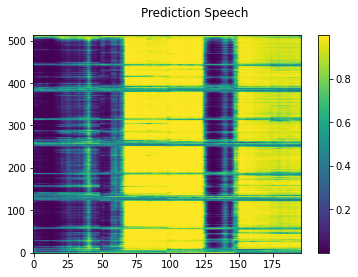

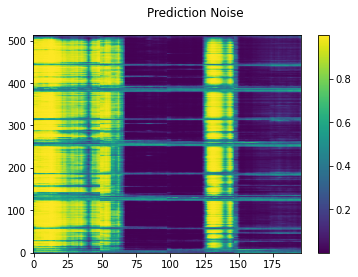

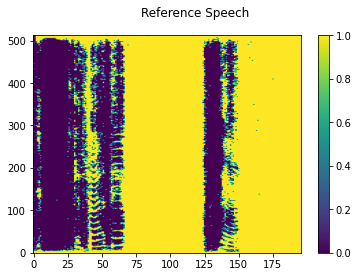

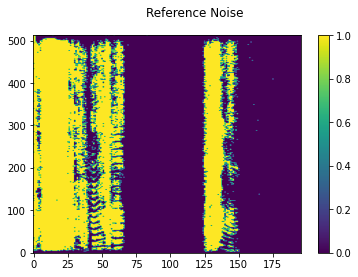

In [15]:
X = X.cpu()
Y = Y.cpu()
def evaluate_example(e_nr):
    model.eval()
    speech_pred = (model(X[e_nr])).float()
    noise_pred = torch.ones([513,X[e_nr].shape[1]])-speech_pred
    plot_mask(speech_pred, title="Prediction Speech")
    plot_mask(noise_pred, title="Prediction Noise")
    plot_mask(Y[e_nr][0], title="Reference Speech")
    plot_mask(Y[e_nr][1], title="Reference Noise")

def plot_mask(mask, title="Mask", xlim=None):
    mask = mask.detach().numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(mask, cmap="viridis", origin="lower", aspect="auto")
    figure.suptitle(title)
    plt.colorbar(img, ax=axis)
    plt.show()

evaluate_example(2010)

In [16]:
istft = torchaudio.transforms.InverseSpectrogram(n_fft=1024, hop_length=256)
def si_snr(estimate, reference, epsilon=1e-8):
    estimate = estimate - estimate.mean()
    reference = reference - reference.mean()
    reference_pow = reference.pow(2).mean(axis=1, keepdim=True)
    mix_pow = (estimate * reference).mean(axis=1, keepdim=True)
    scale = mix_pow / (reference_pow + epsilon)

    reference = scale * reference
    error = estimate - reference

    reference_pow = reference.pow(2)
    error_pow = error.pow(2)

    reference_pow = reference_pow.mean(axis=1)
    error_pow = error_pow.mean(axis=1)

    si_snr = 10 * torch.log10(reference_pow) - 10 * torch.log10(error_pow)
    return si_snr.item()
def evaluateSiSNR(wave, i):
    score = si_snr(wave, speech[i])
    #print(f"Si-SNR score: {score}") 
    return score

def maskToWave(speech_pred,noise_pred,mix,i):
        model.eval()
        psd_transform = torchaudio.transforms.PSD()
        psd_speech = psd_transform(mix[i], speech_pred)
        psd_noise = psd_transform(mix[i], noise_pred)
        mvdr_transform = torchaudio.transforms.SoudenMVDR()
        stft_souden = mvdr_transform(mix[i], psd_speech, psd_noise, reference_channel=0)
        waveform_souden = istft(stft_souden, length=len(speech[i][0]))#X[i].shape[-1])
        return waveform_souden.reshape(-1)

def save_sample(i,wave,sample_rate=SAMPLE_RATE):
    torchaudio.save("./outputs/sample_reference.wav", speech[i].reshape(1,-1),sample_rate)
    torchaudio.save("./outputs/sample_input.wav", mix1[i].reshape(1,-1),sample_rate)
    torchaudio.save("./outputs/model_out.wav",wave.reshape(1,-1),16000)

index = 2017
speech_pred = (model(X[index])).float()
noise_pred = torch.ones([513,speech_pred.shape[1]])-speech_pred
wave = maskToWave(speech_pred,noise_pred,X_complex,index)#X hat nicht mehr nur 2, sondern 4 channel
#print(wave.shape)
#print(wave)
save_sample(index, wave=wave)
#score = evaluateSiSNR(wave,index)#Should be ~28
#print(f"Si-SNR score: {score}")

In [17]:
scores = []
for index in range(2000,2200):
    speech_pred = (model(X[index])).float()
    noise_pred = torch.ones([513,speech_pred.shape[1]])-speech_pred
    wave = maskToWave(speech_pred,noise_pred,X_complex,index)#X hat nicht mehr nur 2, sondern 4 channel
    scores.append(si_snr(wave, speech[index])-si_snr(mix1[index],speech[index]))
print(f"Average Improvement of Si-SNR score on validation set: {np.mean(scores)}") 
# Average improvement with 1 noise => 9.79
# Average improvement with 3 noises => 6.52
# Average improvement with 5 noises => 2.6969
# Average improvement with 10 noises => 0.4515 (5 epochs), 2.537 (29 epochs)
# Average improvement with 100 noises: 1.523 (500 epochs)

Average Improvement of Si-SNR score on validation set: 1.5231493139266967
